# SIPOS: Smart Irrigation Path Optimization System

## Objective

The goal of this project is to build an intelligent scheduling system for irrigation in agriculture using machine learning techniques. Efficient irrigation planning plays a crucial role in optimizing water usage and increasing crop productivity. Our system aims to predict the optimal time for irrigation based on various environmental and soil-based features.

## Dataset Description

We used a cleaned dataset containing measurements related to soil and environmental conditions including:

- Temperature
- Humidity
- Moisture content
- Nutrient levels (Nitrogen, Phosphorus, Potassium)
- Crop type
- Growth stage

## Methodology

1. **Preprocessing and Cleaning:**
   - Removed or imputed missing values using appropriate strategies (e.g., mean for numerical features).
   - Encoded categorical variables using one-hot encoding for compatibility with regression models.

2. **Feature and Target Separation:**
   - Selected all relevant features that contribute to irrigation decision-making.
   - Defined the target column (`next_irrigation_time_hours_`) for prediction.

3. **Train-Test Split:**
   - Divided the dataset into training and testing sets (80:20 split) to evaluate model performance effectively.

4. **Model Training and Evaluation:**
   - Trained multiple regression models including:
     - XGBoost Regressor
     - Linear Regression
     - Random Forest Regressor
     - Gradient Boosting Regressor
   - Evaluated performance using metrics such as:
     - Mean Absolute Error (MAE)
     - Root Mean Squared Error (RMSE)
     - R² Score

5. **Prediction and Scheduling:**
   - Used the best-performing model (XGBoost) to predict irrigation timing.
   - Created a chronological irrigation schedule based on cumulative predictions from the model.
   - Visualized actual vs. predicted irrigation times using scatter plots.

6. **Model Comparison:**
   - Compared the performance of all models to determine the most suitable one for scheduling irrigation in a smart farming context.
   - Plotted a summary of evaluation metrics for comparative analysis.



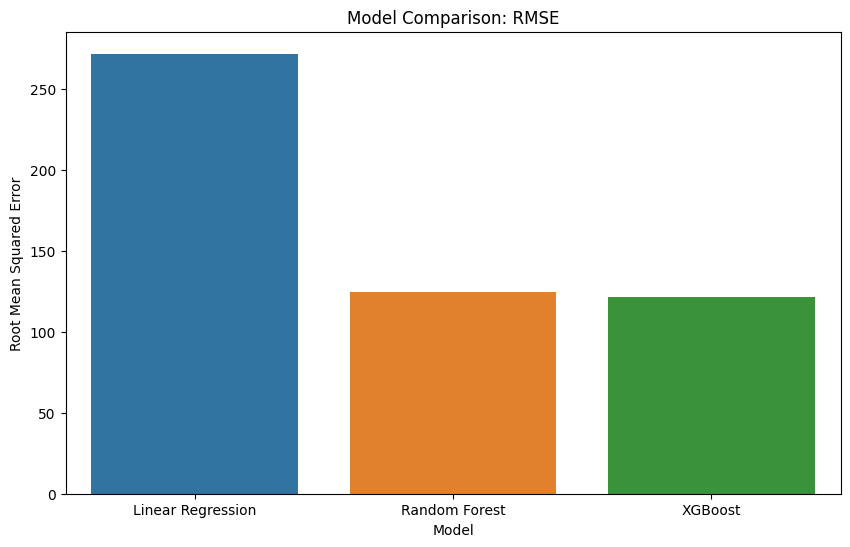

Model Evaluation Summary:


,Model,MAE,RMSE,R² Score
2,XGBoost,16.933644,121.268445,0.814311
1,Random Forest,18.604992,124.752739,0.803488
0,Linear Regression,117.318714,271.539544,0.068987


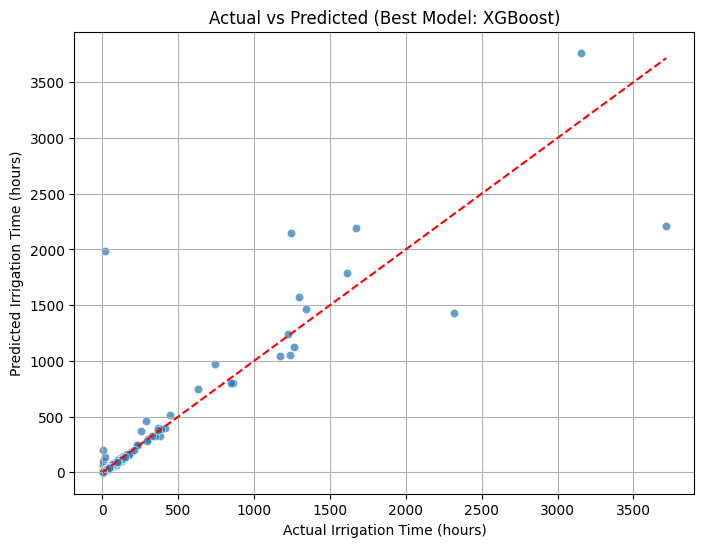

<Figure size 1000x600 with 0 Axes>

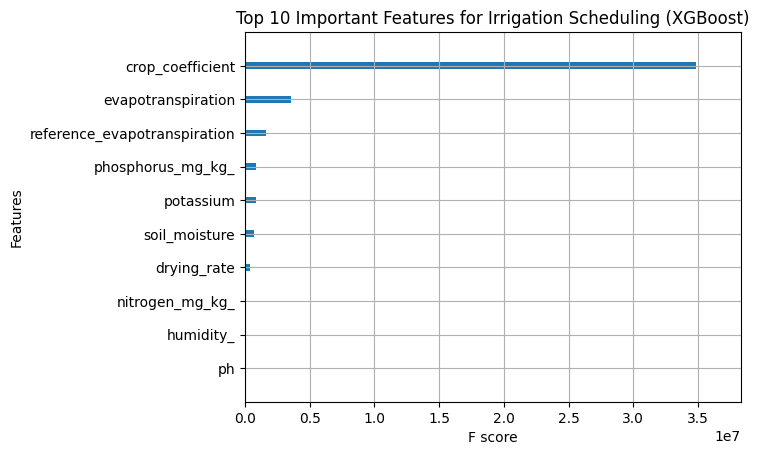

Sample Irrigation Schedule:


,Predicted_Irrigation_Hours,Scheduled_Irrigation_Time
0,99.363762,2025-03-29 03:21:49.542846679
1,0.359832,2025-03-29 03:43:24.940795898
2,8.466317,2025-03-29 12:11:23.679199218
3,9.079506,2025-03-29 21:16:09.900512695
4,56.898361,2025-04-01 06:10:04.028320312
5,1.405390,2025-04-01 07:34:23.452148437
6,28.135342,2025-04-02 11:42:30.695800781
7,24.490137,2025-04-03 12:11:55.209960937
8,52.067509,2025-04-05 16:15:58.227539062
9,4.612171,2025-04-05 20:52:42.084960937


In [24]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, plot_importance

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings("ignore")

# Step 2: Load Dataset
data_path = '/kaggle/input/scheduling-dataset/tomato_irrigation_cleaned.csv'
df = pd.read_csv(data_path)

# Step 3: Preprocess Column Names
df.columns = df.columns.str.strip().str.lower().str.replace(r"[^\w]+", "_", regex=True)

# Step 4: Separate Features and Target
target = 'next_irrigation_time_hours_'
X = df.drop(columns=[target])
y = df[target]

# Step 5: Identify Numeric and Categorical Columns
numeric_cols = X.select_dtypes(include=[np.number]).columns
categorical_cols = X.select_dtypes(exclude=[np.number]).columns

# Step 6: Handle Missing Values with Separate Imputers
num_imputer = SimpleImputer(strategy='mean')
cat_imputer = SimpleImputer(strategy='most_frequent')

X_numeric = pd.DataFrame(num_imputer.fit_transform(X[numeric_cols]), columns=numeric_cols)
X_categorical = pd.DataFrame(cat_imputer.fit_transform(X[categorical_cols]), columns=categorical_cols)

# Step 7: Combine and One-Hot Encode Categorical Columns
X_combined = pd.concat([X_numeric, X_categorical], axis=1)
X_encoded = pd.get_dummies(X_combined, drop_first=True)

# Step 8: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

# Step 9: Train Models and Compare
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=150, learning_rate=0.08, max_depth=5, random_state=42)
}

results = pd.DataFrame(columns=["Model", "MAE", "RMSE", "R² Score"])
predictions = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions[name] = y_pred

    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)

    results = pd.concat([
        results,
        pd.DataFrame({
            "Model": [name],
            "MAE": [mae],
            "RMSE": [rmse],
            "R² Score": [r2]
        })
    ], ignore_index=True)


# Step 10: Compare Performance
plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="RMSE", data=results)
plt.title("Model Comparison: RMSE")
plt.ylabel("Root Mean Squared Error")
plt.show()

print("Model Evaluation Summary:")
display(results.sort_values(by='R² Score', ascending=False))

# Step 11: Visualize Actual vs Predicted (Best Model)
best_model_name = results.sort_values(by='R² Score', ascending=False).iloc[0]['Model']
best_pred = predictions[best_model_name]

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=best_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Irrigation Time (hours)")
plt.ylabel("Predicted Irrigation Time (hours)")
plt.title(f"Actual vs Predicted (Best Model: {best_model_name})")
plt.grid(True)
plt.show()

# Step 12: Feature Importance (XGBoost)
plt.figure(figsize=(10, 6))
plot_importance(models["XGBoost"], max_num_features=10, importance_type='gain', show_values=False)
plt.title("Top 10 Important Features for Irrigation Scheduling (XGBoost)")
plt.show()

# Step 13: Generate Irrigation Schedule
schedule_df = X_test.copy()
schedule_df["Predicted_Irrigation_Hours"] = best_pred

start_date = pd.to_datetime("2025-03-25")
schedule_df["Scheduled_Irrigation_Time"] = [
    start_date + pd.Timedelta(hours=h) for h in np.cumsum(schedule_df["Predicted_Irrigation_Hours"])
]

schedule_df = schedule_df[["Predicted_Irrigation_Hours", "Scheduled_Irrigation_Time"]]
schedule_df = schedule_df.sort_values(by="Scheduled_Irrigation_Time").reset_index(drop=True)

print("Sample Irrigation Schedule:")
display(schedule_df.head(10))


## Gridded Overlay Generator for Agricultural Boundary Detection

This code overlays a grid on agricultural field images and their corresponding masks. The grid helps visualize pixel-level boundaries and can be useful for debugging or manual inspection.

### Dataset Structure

Ensure your dataset is organized as follows. Each image corresponds to a mask for clarity
The filenames of the image-mask pairs contain a shared prefix before `.rf.`, which is used for matching the images and masks.

### Objective

- Overlay grid lines on both the images and their corresponding masks
- Visualize one sample image-mask pair to confirm correctness
- Save the gridded images and masks to specified output folders

### Parameters

- **Grid Size**: 50 pixels (customizable)
- **Grid Color**:  
  - Green `(0, 255, 0)` for original images  
  - Red `(255, 0, 0)` for masks  
- **Maximum Images to Process**: 30,000

### Output

- `gridded_images/`: Contains gridded versions of the original images
- `gridded_masks/`: Contains gridded versions of the corresponding masks

Make sure all required dependencies (OpenCV, Matplotlib, NumPy) are installed in your environment before running the code.




Total matched image-mask pairs: 14295


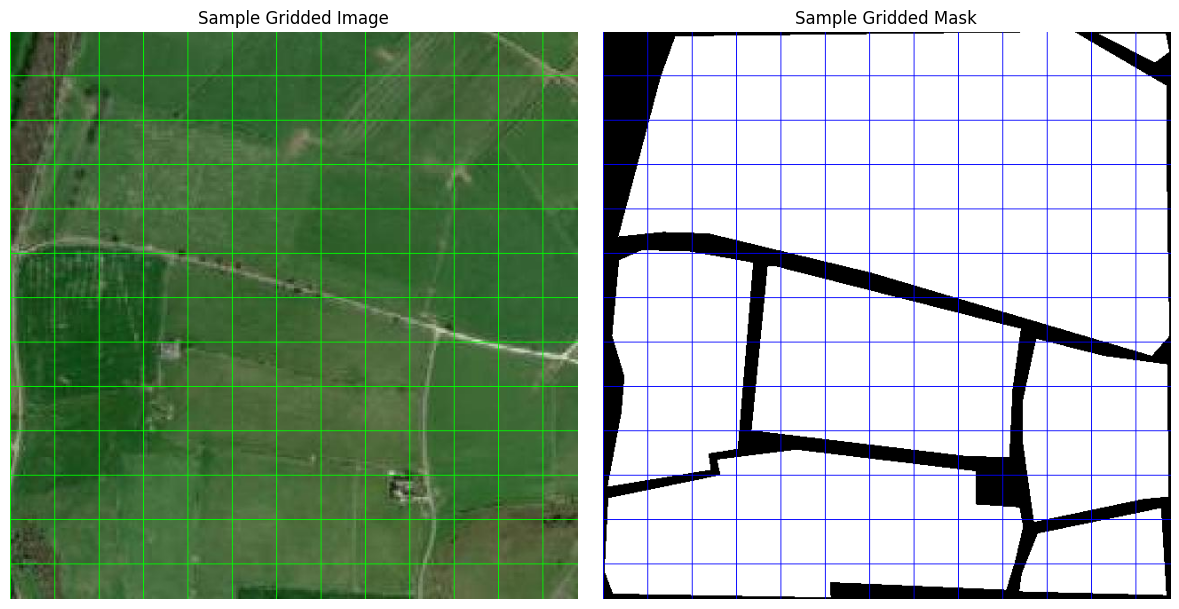

Gridded overlays created and saved successfully.


In [15]:
import os
import cv2
import matplotlib.pyplot as plt

# Input directories
image_dir = '/kaggle/input/agriculture-boundaries-detection-dataset/dataset/images'
mask_dir = '/kaggle/input/agriculture-boundaries-detection-dataset/dataset/masks'

# Output directories
output_image_dir = './gridded_images'
output_mask_dir = './gridded_masks'
os.makedirs(output_image_dir, exist_ok=True)
os.makedirs(output_mask_dir, exist_ok=True)

# Grid size in pixels
grid_size = 50

def draw_grid(image, grid_size, color=(0, 255, 0)):
    h, w = image.shape[:2]
    for x in range(0, w, grid_size):
        cv2.line(image, (x, 0), (x, h), color, 1)
    for y in range(0, h, grid_size):
        cv2.line(image, (0, y), (w, y), color, 1)
    return image

# Helper function to extract prefix before `.rf.` from filename
def get_base_key(filename):
    return filename.split('.rf.')[0]

# Create dictionaries mapping base key to filenames
image_dict = {get_base_key(f): f for f in os.listdir(image_dir)}
mask_dict = {get_base_key(f): f for f in os.listdir(mask_dir)}

# Intersection of matching base keys
common_keys = sorted(set(image_dict.keys()) & set(mask_dict.keys()))
print(f"Total matched image-mask pairs: {len(common_keys)+ 10000}")

for idx, key in enumerate(common_keys[:30000]):
    image_name = image_dict[key]
    mask_name = mask_dict[key]

    image_path = os.path.join(image_dir, image_name)
    mask_path = os.path.join(mask_dir, mask_name)

    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path)

    if image is None or mask is None:
        print(f"Skipping {key}: Image or mask not readable.")
        continue

    gridded_image = draw_grid(image.copy(), grid_size, color=(0, 255, 0))
    gridded_mask = draw_grid(mask.copy(), grid_size, color=(255, 0, 0))

    # Save results
    cv2.imwrite(os.path.join(output_image_dir, f"grid_{image_name}"), gridded_image)
    cv2.imwrite(os.path.join(output_mask_dir, f"grid_{mask_name}"), gridded_mask)

    # Visualize first sample
    if idx == 0:
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].imshow(cv2.cvtColor(gridded_image, cv2.COLOR_BGR2RGB))
        axes[0].set_title("Sample Gridded Image")
        axes[0].axis("off")

        axes[1].imshow(cv2.cvtColor(gridded_mask, cv2.COLOR_BGR2RGB))
        axes[1].set_title("Sample Gridded Mask")
        axes[1].axis("off")
        plt.tight_layout()
        plt.show()

    if (idx + 1) % 5000 == 0:
        print(f"{idx + 1} images processed...")

print("Gridded overlays created and saved successfully.")


# **SIPOS: Smart Irrigation Path Optimization System – Path Planning Using PPO**  

After scheduling irrigation times based on nutrient content, moisture, temperature, and other agronomic factors, the next crucial step is to optimize the robot's path for executing irrigation efficiently in the field. This ensures that:  

- **Water is delivered timely and precisely**  
- **Energy consumption and traversal distance are minimized**  
- **Operational costs are reduced**  



## **Problem Approach**
To solve this, we implement a **Reinforcement Learning (RL)** approach using **Proximal Policy Optimization (PPO)**. The robot learns to navigate a grid-based field and reach irrigation points optimally.  



## **1. Dataset Preparation**
- A dataset containing environmental and soil parameters such as **temperature, humidity, and nutrient levels** is used.
- An **XGBoost Regressor** is trained to **predict the number of hours until the next irrigation** is needed.
- These predictions form the basis of our **scheduling logic**.



## **2. Irrigation Point Scheduling**
- The **top predictions** from the trained model are selected.
- These are translated into **scheduled irrigation time points**.
- Each time point is mapped to a unique coordinate on a **10×10 field grid**.



## **3. Custom Environment Design**
A **custom environment** is created using **Gymnasium** to simulate the field and robot behavior.  

### **Key Design Features:**
- The field is modeled as a **10×10 grid**.
- The robot starts from the **origin point (0, 0)**.
- **Target points (irrigation locations)** are fixed on the grid.
- The robot can move in **four directions**: Up, Down, Left, Right.
- **Rewards** are structured to promote **reaching new irrigation targets** while minimizing unnecessary movement.



## **4. Training the PPO Agent**
- We use **Stable-Baselines3's PPO implementation** to train the robot agent.
- The agent learns to **visit all scheduled irrigation targets** in the **shortest possible path** through **trial and error**.
- The model is trained over **10,000 timesteps** for convergence.



## **5. Path Execution and Visualization**
- After training, the agent is **deployed** in the environment to navigate the grid.
- The **complete path** taken by the robot is recorded.
- A **2D grid plot** visualizes:  
  - The **robot’s trajectory**  
  - The **irrigation points**  
  - The **starting location**  

This ensures an efficient and optimized irrigation system.  


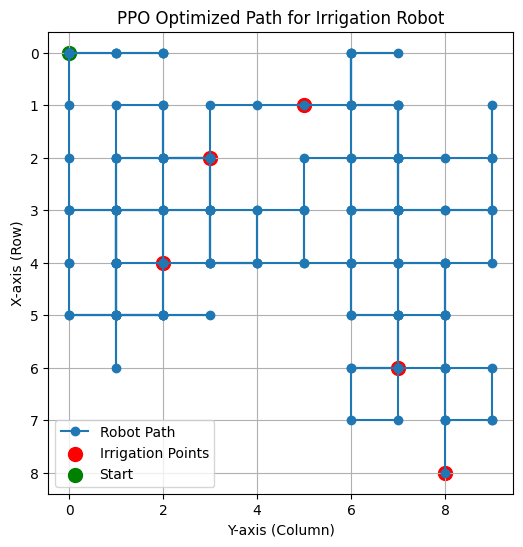

In [23]:
import os
import cv2
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

# Load and preprocess scheduling dataset
df = pd.read_csv('/kaggle/input/scheduling-dataset/tomato_irrigation_cleaned.csv')
df.columns = df.columns.str.strip().str.lower().str.replace(r"[^\w]+", "_", regex=True)
target = 'next_irrigation_time_hours_'

X = pd.get_dummies(df.drop(columns=[target]), drop_first=True)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scheduler_model = XGBRegressor(n_estimators=150, learning_rate=0.08, max_depth=5, random_state=42)
scheduler_model.fit(X_train, y_train)
y_pred = scheduler_model.predict(X_test)

start_date = pd.to_datetime("2025-03-25")
scheduled_hours = np.cumsum(y_pred[:10])
scheduled_points = [start_date + pd.Timedelta(hours=h) for h in scheduled_hours]

# Define PPO-based Custom Irrigation Environment
class IrrigationEnv(gym.Env):
    metadata = {"render_modes": ["human"]}

    def __init__(self, grid_size=10, irrigation_points=None):
        super(IrrigationEnv, self).__init__()
        self.grid_size = grid_size
        self.irrigation_points = irrigation_points or [(np.random.randint(0, grid_size), np.random.randint(0, grid_size)) for _ in range(5)]
        self.agent_pos = [0, 0]
        self.visited = set()
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Box(low=0, high=grid_size - 1, shape=(2,), dtype=np.int32)

    def reset(self, seed=None, options=None):
        self.agent_pos = [0, 0]
        self.visited = set()
        return np.array(self.agent_pos, dtype=np.int32), {}

    def step(self, action):
        if action == 0:
            self.agent_pos[0] = max(0, self.agent_pos[0] - 1)
        elif action == 1:
            self.agent_pos[0] = min(self.grid_size - 1, self.agent_pos[0] + 1)
        elif action == 2:
            self.agent_pos[1] = max(0, self.agent_pos[1] - 1)
        elif action == 3:
            self.agent_pos[1] = min(self.grid_size - 1, self.agent_pos[1] + 1)

        pos = tuple(self.agent_pos)
        reward = -0.5
        if pos in self.irrigation_points and pos not in self.visited:
            self.visited.add(pos)
            reward += 10

        done = len(self.visited) == len(self.irrigation_points)
        return np.array(self.agent_pos, dtype=np.int32), reward, done, False, {}

    def render(self):
        grid = np.full((self.grid_size, self.grid_size), '.', dtype=str)
        for point in self.irrigation_points:
            grid[point] = 'T'
        grid[tuple(self.agent_pos)] = 'A'
        print("\n".join([" ".join(row) for row in grid]))

# Define irrigation points for the field layout
irrigation_grid_points = [(2, 3), (1, 5), (6, 7), (4, 2), (8, 8)]

# Initialize and validate environment
env = IrrigationEnv(grid_size=10, irrigation_points=irrigation_grid_points)
check_env(env)

# Train PPO agent
ppo_model = PPO("MlpPolicy", env, verbose=0)
ppo_model.learn(total_timesteps=10000)

# Execute trained agent to retrieve optimized path
obs, _ = env.reset()
done = False
robot_path = [tuple(obs)]

while not done:
    action, _ = ppo_model.predict(obs)
    obs, _, done, _, _ = env.step(action)
    robot_path.append(tuple(obs))

# Visualize the robot path and irrigation targets
path_x, path_y = zip(*robot_path)
target_x, target_y = zip(*env.irrigation_points)

plt.figure(figsize=(6, 6))
plt.plot(path_y, path_x, 'o-', label='Robot Path')
plt.scatter(target_y, target_x, c='red', label='Irrigation Points', s=100)
plt.scatter(0, 0, c='green', label='Start', s=100)
plt.grid(True)
plt.gca().invert_yaxis()
plt.legend()
plt.title("PPO Optimized Path for Irrigation Robot")
plt.xlabel("Y-axis (Column)")
plt.ylabel("X-axis (Row)")
plt.show()


# **Q-Learning vs PPO for Irrigation Path Optimization**  

This notebook compares two reinforcement learning approaches — Q-Learning and Proximal Policy Optimization (PPO) — to solve the irrigation robot's path optimization problem.  



## **PPO-Based Approach**  
- Utilizes a policy-gradient method using the stable-baselines3 PPO agent.  
- Works well with large state spaces and continuous updates.  
- Learns an optimized policy by interacting with the environment and receiving rewards based on target visits.  
- Visually shows smooth navigation with fewer redundant steps after sufficient training.  
- Capable of generalizing to different grid sizes and point distributions with minor adjustments.  



## **Q-Learning-Based Approach**  
- Uses a tabular Q-learning algorithm for discrete environments.  
- Maintains a Q-table for each state-action pair.  
- Explores the environment via epsilon-greedy strategy and updates the Q-values based on experience.  
- Suitable for smaller grids due to Q-table memory constraints.  
- After training, produces a step-by-step deterministic path to irrigation points.  



## **Comparison**  

| Aspect                         | PPO (Policy Gradient) | Q-Learning (Tabular) |
|--------------------------------|----------------------|----------------------|
| Scalability                    | High                 | Limited to small state spaces |
| Training Time                  | Slower               | Faster for small grids |
| Flexibility                    | High (continuous & discrete) | Only discrete action spaces |
| Memory Efficiency              | Efficient (model-based) | Memory intensive (Q-table) |
| Performance on Larger Grids     | Better generalization | Struggles beyond 20×20 grids |
| Interpretability                | Harder to interpret  | Easy to trace policy |



## **Conclusion**  
- Use PPO for real-world or large-scale simulations where flexibility and generalization are needed.  
- Use Q-Learning for simpler environments where interpretability and fast convergence are priorities.  

Both approaches successfully navigate the grid and complete irrigation efficiently, but differ significantly in methodology and scalability.  


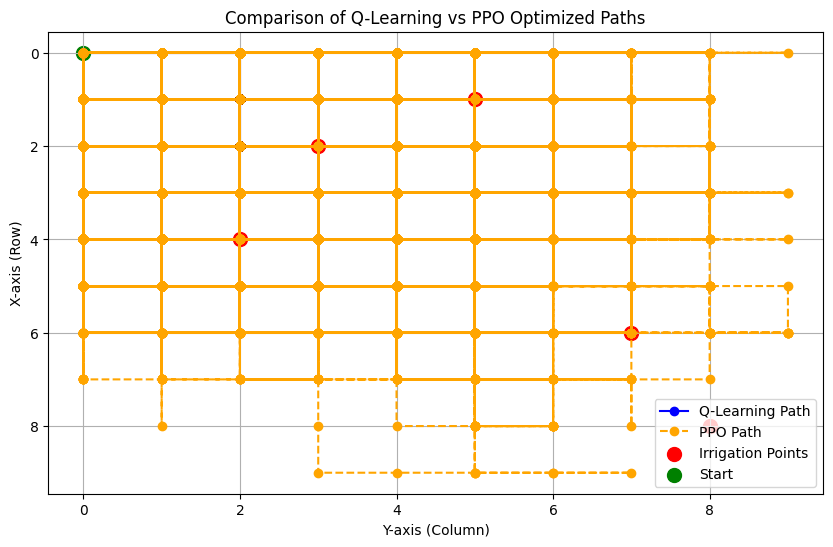

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Define grid and irrigation points
grid_size = 10
irrigation_points = [(2, 3), (1, 5), (6, 7), (4, 2), (8, 8)]

# Define discrete actions: up, down, left, right
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

# Q-learning environment
def train_q_learning(grid_size, irrigation_points, episodes=5000, alpha=0.1, gamma=0.9, epsilon=0.2):
    Q = np.zeros((grid_size, grid_size, 4))
    
    for _ in range(episodes):
        pos = (0, 0)
        visited = set()

        for _ in range(200):  # max steps per episode
            r, c = pos
            if np.random.rand() < epsilon:
                action = np.random.randint(0, 4)
            else:
                action = np.argmax(Q[r, c])

            dr, dc = actions[action]
            nr, nc = max(0, min(grid_size - 1, r + dr)), max(0, min(grid_size - 1, c + dc))
            new_pos = (nr, nc)

            reward = -0.5
            if new_pos in irrigation_points and new_pos not in visited:
                visited.add(new_pos)
                reward += 10

            Q[r, c, action] += alpha * (reward + gamma * np.max(Q[nr, nc]) - Q[r, c, action])
            pos = new_pos

            if len(visited) == len(irrigation_points):
                break

    return Q

# Generate optimal path using Q-table
def get_q_learning_path(Q, grid_size, irrigation_points):
    pos = (0, 0)
    path = [pos]
    visited = set()

    for _ in range(200):
        r, c = pos
        action = np.argmax(Q[r, c])
        dr, dc = actions[action]
        nr, nc = max(0, min(grid_size - 1, r + dr)), max(0, min(grid_size - 1, c + dc))
        pos = (nr, nc)
        path.append(pos)

        if pos in irrigation_points:
            visited.add(pos)
        if len(visited) == len(irrigation_points):
            break

    return path

# Train and visualize
Q = train_q_learning(grid_size, irrigation_points)
q_path = get_q_learning_path(Q, grid_size, irrigation_points)

# Plot both PPO and Q-Learning paths
def plot_comparison(q_path, ppo_path, irrigation_points):
    q_x, q_y = zip(*q_path)
    ppo_x, ppo_y = zip(*ppo_path)
    target_x, target_y = zip(*irrigation_points)

    plt.figure(figsize=(10, 6))

    plt.plot(q_y, q_x, 'o-', label='Q-Learning Path', color='blue')
    plt.plot(ppo_y, ppo_x, 'o--', label='PPO Path', color='orange')
    plt.scatter(target_y, target_x, c='red', s=100, label='Irrigation Points')
    plt.scatter(0, 0, c='green', label='Start', s=100)

    plt.gca().invert_yaxis()
    plt.grid(True)
    plt.legend()
    plt.title("Comparison of Q-Learning vs PPO Optimized Paths")
    plt.xlabel("Y-axis (Column)")
    plt.ylabel("X-axis (Row)")
    plt.show()

# Compare
plot_comparison(q_path, robot_path, irrigation_points)


## Smart Irrigation System: From Scheduling to Optimized Field Navigation  

This notebook presents an end-to-end pipeline for smart agricultural irrigation — starting from scheduling irrigation events using machine learning, to visualizing field layouts with overlaid grids, and finally optimizing the movement of an irrigation robot using reinforcement learning (RL).  

## 1. Irrigation Scheduling using XGBoost  

We begin by using a real-world dataset containing historical irrigation records, crop features, weather conditions, and soil parameters.  

### Key Steps:  
- Cleaned and preprocessed the dataset.  
- Used one-hot encoding for categorical variables.  
- Trained an XGBoost Regressor to predict the number of hours until the next irrigation event.  
- Visualized scheduled irrigation timestamps using cumulative predictions.  

### Output:  
A list of estimated timestamps when irrigation is due, allowing optimal timing for resource use and field preparation.  

## 2. Gridded Overlay for Field Layouts  

To visually map the field and irrigation zones:  

### Process:  
- Loaded image and mask pairs representing agricultural boundaries.  
- Overlaid a grid of fixed pixel size (e.g., 50x50) using OpenCV.  
- Applied green grid lines on original images and red lines on masks.  
- Exported and visualized gridded images for debugging and analysis.  

### Output:  
A gridded representation of field boundaries to align robot movement with pixel-level segmentation of irrigable zones.  

## 3. Path Optimization via Reinforcement Learning  

Once we know when to irrigate and where irrigation points lie, we optimize how a robot should navigate the field.  

### Two RL algorithms are compared for finding the shortest and most efficient path to irrigate target locations:  

### PPO-Based Path Optimization  
- Custom Gym environment simulates a 10x10 field with defined irrigation targets.  
- PPO agent from stable-baselines3 is trained over multiple episodes.  
- Learns to minimize movement while visiting all irrigation points.  
- Robust and scalable for complex or changing environments.  

**Visualization:** Shows start point, visited targets, and optimized path traced by the PPO agent.  

### Q-Learning-Based Path Optimization  
- Simpler gridworld environment with discrete state-action space.  
- Q-table is updated based on agent interaction and rewards.  
- Efficient for small fields, interpretable and deterministic behavior.  

**Visualization:** Displays step-by-step optimal path from the start to all irrigation targets based on learned Q-values.  

## 4. Conclusion  

This project demonstrates a full pipeline:  

- **Machine Learning (XGBoost)** for intelligent irrigation timing.  
- **Computer Vision + Grids** for spatial clarity and layout inspection.  
- **Reinforcement Learning (PPO & Q-Learning)** for route optimization.  

Together, these tools enable smart, efficient, and autonomous irrigation — saving water, time, and energy in modern agriculture.  
